In [1]:
import numpy as np
import struct
import os
from array import array
from os.path  import join

# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [2]:
import random
import matplotlib.pyplot as plt

# Set file paths based on added MNIST Datasets
input_path = join(os.getcwd(), 'datasets')
training_images_filepath = join(input_path, 'train-images-idx3-ubyte.gz')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte.gz')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte.gz')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte.gz')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

#show_images(images_2_show, titles_2_show)

x_train = np.array(x_train).reshape((len(x_train), -1))
y_train = np.array(y_train)
x_test = np.array(x_test).reshape((len(x_test), -1))
y_test = np.array(y_test)
print("Training Set Data  Shape: ", x_train.shape)
print("Training Set Label Shape: ", y_train.shape)
print("Test Set Data  Shape: ", x_test.shape)
print("Test Set Label Shape: ", y_test.shape)

random_prototyping_accuracy = []
cnn_accuracy = []
sample_sizes = []

Training Set Data  Shape:  (60000, 784)
Training Set Label Shape:  (60000,)
Test Set Data  Shape:  (10000, 784)
Test Set Label Shape:  (10000,)


In [3]:
def run_knn(x_train, y_train, x_test, y_test, k):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import metrics
    
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train, y_train)

    y_test_pred = knn_model.predict(x_test)
    test_acc = metrics.accuracy_score(y_test, y_test_pred)

    #print("KNN Test Accuracy: ", test_acc*100, "%")
    return test_acc

In [4]:
def get_random_idx(sample_size, data_size):
    rand_idx = np.array(sample_size, dtype=int)
    rand_idx = np.int_(np.round(np.random.rand(sample_size) * (data_size-1)))
    return rand_idx

def plot_accuracies(sample_size, random_accuracy, custom_accuracy):
    import matplotlib.pyplot as plt
    
    #y = np.sum(random_accuracy, axis=1)/random_accuracy.shape[1]
    #yerr = np.std(random_accuracy, axis=1)
    #plt.figure()
    #plt.errorbar(sample_size, y, yerr)

    X_axis = np.arange(len(sample_size))
    plt.bar(X_axis-0.2, random_accuracy, 0.4, label='random')
    plt.bar(X_axis+0.2, custom_accuracy, 0.4, label='custom')
    plt.ylim([min(min(random_accuracy), min(custom_accuracy))-0.1, max(max(random_accuracy), max(custom_accuracy))+0.1])
    plt.xticks(X_axis, sample_size)
    plt.xlabel("Sample size")
    plt.ylabel("Test Accuracy")
    plt.legend()
    plt.show()

def plot_errbar(x, y1, y2, yerr1, yerr2):
    #y = np.sum(random_accuracy, axis=1)/random_accuracy.shape[1]
    #yerr = np.std(random_accuracy, axis=1)
    plt.figure()
    plt.errorbar(x, y1, yerr1, label='KMeans')
    plt.errorbar(x, y2, yerr2, label='Random')
    plt.legend()
    plt.show()


def compare_random(sample_size):
    rand_idx = get_random_idx(sample_size, x_train.shape[0])
    rand_data = np.take(x_train, rand_idx, axis=0)
    rand_labels = np.take(y_train, rand_idx, axis=0)
    
    rand_test_acc = run_knn(rand_data, rand_labels, x_test, y_test, 1)
    print("Random selection of ", sample_size, " samples, Test accuracy: ", rand_test_acc)
    random_prototyping_accuracy.append(rand_test_acc)
    return rand_test_acc

In [5]:
def initialize_cnn_subset(checkpoint_file_path, y_tr):
    subset_idxs = []
    #with open(checkpoint_file_path, 'r') as f:
    #    for id in f:
    #        subset_idxs.append(int(id))
    
    if(len(subset_idxs) > 10):
        print("Initialized subset from checkpoint file: ", subset_idxs)
    else:
        for i in range(10): #mnist label classes
            ids = np.flatnonzero(y_tr == i)
            subset_idxs.append(np.random.choice(ids))
            if(ids.shape[0] == 0):
                print("Not entry of label ", i, " in training data")
            #for j in range(100):
            #    if(y_tr[j] == i):
            #        subset_idxs.append(j)
            #        found = 1
            #        break
            #if(found == 0):
            #    print("Couldn't find a label in 100 attempts")
    
    return subset_idxs

def condense(subset_idxs, x_train, y_train, x_test, y_test, checkpoint_file_path):
    subset_idxs = np.array(subset_idxs)
    iter = 0
    train_acc = run_knn(np.take(x_train, subset_idxs, axis=0), np.take(y_train, subset_idxs, axis=0), x_train, y_train, 1)
    test_acc = run_knn(np.take(x_train, subset_idxs, axis=0), np.take(y_train, subset_idxs, axis=0), x_test, y_test, 1)
    print("Initial subset size: ", subset_idxs.shape[0], " Training accuracy: ", train_acc, " Test Accuracy: ", test_acc)
    while(train_acc < 1.):
        for i in range(x_train.shape[0]):
            if(i in subset_idxs):
                pass
            else:
                found = run_knn(np.take(x_train, subset_idxs, axis=0), np.take(y_train, subset_idxs, axis=0), np.reshape(x_train[i], (1,-1)), np.reshape(y_train[i], (1,-1)), 1)
                if(found < 0.5):
                    subset_idxs = np.append(subset_idxs, i)
                    #print("TR idx: ", i, ", Subset size: ", subset_idxs.shape[0])
        train_acc = run_knn(np.take(x_train, subset_idxs, axis=0), np.take(y_train, subset_idxs, axis=0), x_train, y_train, 1)
        test_acc = run_knn(np.take(x_train, subset_idxs, axis=0), np.take(y_train, subset_idxs, axis=0), x_test, y_test, 1)
        print("[Iter ", iter, "] Subset size: ", subset_idxs.shape[0], " Training accuracy: ", train_acc, " Test Accuracy: ", test_acc)
        sample_sizes.append(subset_idxs.shape[0])
        cnn_accuracy.append(test_acc)
        compare_random(subset_idxs.shape[0])
        iter += 1
    
    with open(checkpoint_file_path, 'w') as f:
        for subset_idx in subset_idxs:
            f.write("%s\n" % subset_idx)
        
    return subset_idxs

def modified_condense(x_train, y_train, x_test, y_test):
    #subset_idxs = np.array()
    #remaining_idxs = np.arange(0, x_train.shape[0], 1, dtype=int)
    subset_data = []
    subset_labels = []

    for i in range(10): #mnist label classes
        for j in range(100):
            if(y_train[j] == i):
                subset_data.append(x_train[j])
                subset_labels.append(i) #y_train[j]
                found = 1
                break
        if(found == 0):
            print("Couldn't find a label in 100 attempts")

    subset_data = np.array(subset_data)
    subset_labels = np.array(subset_labels)
    print("Initial Subset size: ", subset_data.shape, " ", subset_labels.shape)
    train_acc = 0
    iter = 0
    prev_misclassified_idxs = []
    misclassified_idxs = []
    while(train_acc < 0.94):
        if(len(misclassified_idxs) > 0.99*x_train.shape[0]):
            misclassified_idxs = []
        misclassified_data = []
        misclassified_labels = []
        for i in range(x_train.shape[0]):
            #if(i in misclassified_idxs):
            #    pass
            #else:
            found = run_knn(subset_data, subset_labels, np.reshape(x_train[i], (1,-1)), np.reshape(y_train[i], (1,-1)), 1)
            if(found < 0.5):
                misclassified_idxs.append(i)
                misclassified_data.append(x_train[i])
                misclassified_labels.append(y_train[i])
        train_acc = run_knn(subset_data, subset_labels, x_train, y_train, 1)
        test_acc = run_knn(subset_data, subset_labels, x_test, y_test, 1)
        print("[Iter ", iter, "] Subset size: ", subset_data.shape[0], " Misclassified: ", len(misclassified_data), " Training accuracy: ", train_acc, " Test Accuracy: ", test_acc)
        misclassified_data = np.array(misclassified_data)
        misclassified_labels = np.array(misclassified_labels)
        for label in range(10):
            idxs = np.flatnonzero(misclassified_labels == label)
            if(idxs.shape[0] != 0):
                #print(idxs.shape[0], " points of label ", label, " misclassified")
                centroid_data =  np.sum(np.take(misclassified_data, idxs, axis=0), axis=0).reshape(1, misclassified_data.shape[1])/idxs.shape[0]
                #print("Adding centroid of all these points to subset: ", centroid_data.shape)
                subset_data = np.append(subset_data, centroid_data, axis=0)
                subset_labels = np.append(subset_labels, label)
        #print("Iter ", iter, "New Subset size: ", subset_data.shape, " ", subset_labels.shape)
        iter += 1


In [6]:
def get_labelwise_k(x_tr, y_tr, sample_size):
    labelwise_count = np.zeros(10)
    for i in range(10):
        labelwise_count[i] = np.flatnonzero(y_tr == i).shape[0]
    assert np.sum(labelwise_count) == y_tr.shape[0]
    #print("Labelwise count in training data: ", labelwise_count)
    scaling_factor = sample_size/y_tr.shape[0]
    #print("Scaling factor: ", scaling_factor)
    labelwise_count = np.int_(np.round(labelwise_count*scaling_factor))
    if(np.sum(labelwise_count) != sample_size):
        for i in range(abs(np.sum(labelwise_count)-sample_size)):
            if(np.sum(labelwise_count) > sample_size):
                labelwise_count[np.int_(np.round(np.random.rand(1)*9))] -= 1
            else:
                labelwise_count[np.int_(np.round(np.random.rand(1)*9))] += 1
    #print("Labelwise count needed: ", labelwise_count, " Total: ", np.sum(labelwise_count))
    return labelwise_count

def k_meanest_neighbours(x_tr, y_tr, sample_size):
    # 1. Find count per label of original training set
    # 2. Multiply all counts with scaling factor of sample_size/training_set_size
    # 3. Do K means clustering of each label's training points with K found in step 2
    
    new_x_tr = np.zeros((1,x_tr.shape[1]))
    new_y_tr = np.zeros((1,))
    labelwise_num_centroids = get_labelwise_k(x_tr, y_tr, sample_size)
    from sklearn.cluster import KMeans
    
    for i in range(10):
        label_ids = np.flatnonzero(y_tr == i)
        label_subset = np.take(x_tr, label_ids, axis=0)
        #kmm = KMeans(n_clusters=labelwise_num_centroids[i], random_state=0).fit(label_subset)
        kmm = KMeans(n_clusters=labelwise_num_centroids[i]).fit(label_subset)
        kmm_centroids = kmm.cluster_centers_
        #print("Centroids for label ", i, ": ", kmm_centroids.shape)
        new_x_tr = np.append(new_x_tr, kmm_centroids, axis=0)
        new_labels = np.ones(labelwise_num_centroids[i])*i
        new_y_tr = np.append(new_y_tr, new_labels, axis=0)
        #print("New training data: ", new_x_tr.shape, new_y_tr.shape)
    
    new_x_tr = new_x_tr[1:]
    new_y_tr = new_y_tr[1:]
    return new_x_tr, new_y_tr

In [7]:
#### First setup: KMeans vs Random
#### Since we can control the size of the subset in KMeans, it is straightforward to compare it with Random
#### 5 iterations are done for each method for each sample size

exp1_M = [1000, 5000, 10000]
n_iter = 5
exp1_kmm_accuracy = []
exp1_rand_accuracy = []
exp1_kmm_stddev = []
exp1_rand_stddev = []

for i, m in enumerate(exp1_M):
    acc1 = np.zeros(n_iter)
    acc2 = np.zeros(n_iter)
    print("=============== M: ", m, " ==============")
    for j in range(n_iter):    
        new_x_train, new_y_train = k_meanest_neighbours(x_train, y_train, m)
        kmm_test_acc = run_knn(new_x_train, new_y_train, x_test, y_test, 1)
        print("[Iteration ", j, "] KMeans clustered to sample size ", m, ": ", kmm_test_acc)
        acc1[j] = kmm_test_acc
        rand_test_acc = compare_random(m)
        #print("[Iteration ", j, "] Random selection of sample size ", m, ": ", rand_test_acc)
        acc2[j] = rand_test_acc
    exp1_kmm_accuracy.append(np.sum(acc1)/acc1.shape[0])
    exp1_rand_accuracy.append(np.sum(acc2)/acc2.shape[0])
    exp1_kmm_stddev.append(np.std(acc1))
    exp1_rand_stddev.append(np.std(acc2))

#print("Sample sizes: ", exp1_M)
#print("KMeans results, means and stddev: ", exp1_kmm_accuracy, exp1_kmm_stddev)
#print("Random results, means and stddev: ", exp1_rand_accuracy, exp1_rand_stddev)
#plot_errbar(np.array(exp1_M), exp1_kmm_accuracy, exp1_rand_accuracy, exp1_kmm_stddev, exp1_rand_stddev)

=============== M:  1000  ==============
[Iteration  0 ] KMeans clustered to sample size  1000 :  0.9576
Random selection of  1000  samples, Test accuracy:  0.88
[Iteration  1 ] KMeans clustered to sample size  1000 :  0.957
Random selection of  1000  samples, Test accuracy:  0.8862
[Iteration  2 ] KMeans clustered to sample size  1000 :  0.9574
Random selection of  1000  samples, Test accuracy:  0.8872
[Iteration  3 ] KMeans clustered to sample size  1000 :  0.9583
Random selection of  1000  samples, Test accuracy:  0.8782
[Iteration  4 ] KMeans clustered to sample size  1000 :  0.9611
Random selection of  1000  samples, Test accuracy:  0.886
=============== M:  5000  ==============
[Iteration  0 ] KMeans clustered to sample size  5000 :  0.968
Random selection of  5000  samples, Test accuracy:  0.9347
[Iteration  1 ] KMeans clustered to sample size  5000 :  0.9687
Random selection of  5000  samples, Test accuracy:  0.9352
[Iteration  2 ] KMeans clustered to sample size  5000 :  0.967

Initial subset size:  10  Training accuracy:  0.43255  Test Accuracy:  0.4345
[Iter  0 ] Subset size:  4963  Training accuracy:  0.9798666666666667  Test Accuracy:  0.9303
Random selection of  4963  samples, Test accuracy:  0.9331
[Iter  1 ] Subset size:  6177  Training accuracy:  0.99765  Test Accuracy:  0.9392
Random selection of  6177  samples, Test accuracy:  0.9394
[Iter  2 ] Subset size:  6335  Training accuracy:  0.9998  Test Accuracy:  0.9404
Random selection of  6335  samples, Test accuracy:  0.9391
[Iter  3 ] Subset size:  6347  Training accuracy:  0.9999833333333333  Test Accuracy:  0.9402
Random selection of  6347  samples, Test accuracy:  0.9398
[Iter  4 ] Subset size:  6348  Training accuracy:  1.0  Test Accuracy:  0.9402
Random selection of  6348  samples, Test accuracy:  0.9393


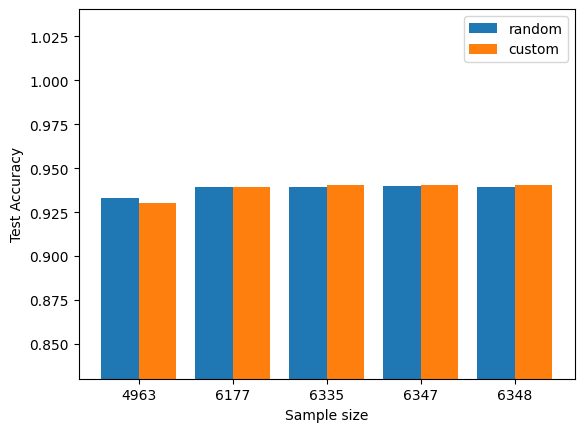

In [8]:
random_prototyping_accuracy = []
cnn_accuracy = []
sample_sizes = []
checkpoint_file = 'cnn_subset_idxs.txt'

cnn_subset_ids = initialize_cnn_subset(checkpoint_file, y_train)
cnn_subset_ids = condense(cnn_subset_ids, x_train, y_train, x_test, y_test, checkpoint_file)
plot_accuracies(sample_sizes, random_prototyping_accuracy, cnn_accuracy)


In [9]:
#### Third setup: Condensed Nearest Neighbours followed by KMeans
#### Note: Condensed NNs are calculated in a previous cell above, but because the computation is time consuming, the subset has been stored in a file to use later and compare results quickly
#### Since we cannot control the Condensed subset size, and it comes out ~6300 samples for this training data, we further combine it with KMeans clustering to reduce the sample size to 1000 and 5000 
subset_ids_for_kmm =[]
with open('cnn_subset_idxs_6303_94p3.txt', 'r') as f:
        for id in f:
            subset_ids_for_kmm.append(int(id))

kmm_x_tr = np.take(x_train, np.array(subset_ids_for_kmm), axis=0)
kmm_y_tr = np.take(y_train, np.array(subset_ids_for_kmm), axis=0)

exp3_M = [1000, 5000]
n_iter = 5
exp3_kmm_accuracy = []
exp3_rand_accuracy = []
exp3_kmm_stddev = []
exp3_rand_stddev = []

for i, m in enumerate(exp3_M):
    acc1 = np.zeros(n_iter)
    acc2 = np.zeros(n_iter)
    print("=============== M: ", m, " ==============")
    for j in range(n_iter):    
        new_x_train, new_y_train = k_meanest_neighbours(kmm_x_tr, kmm_y_tr, m)
        kmm_test_acc = run_knn(new_x_train, new_y_train, x_test, y_test, 1)
        print("[Iteration ", j, "] Condensed +  KMeans clustered to sample size ", m, ": ", kmm_test_acc)
        acc1[j] = kmm_test_acc
        rand_test_acc = compare_random(m)
        #print("[Iteration ", j, "] Random selection of sample size ", m, ": ", rand_test_acc)
        acc2[j] = rand_test_acc
    exp3_kmm_accuracy.append(np.sum(acc1)/acc1.shape[0])
    exp3_rand_accuracy.append(np.sum(acc2)/acc2.shape[0])
    exp3_kmm_stddev.append(np.std(acc1))
    exp3_rand_stddev.append(np.std(acc2))

#print("Sample sizes: ", exp3_M)
#print("KMeans results, means and stddev: ", exp3_kmm_accuracy, exp3_kmm_stddev)
#print("Random results, means and stddev: ", exp3_rand_accuracy, exp3_rand_stddev)
#plot_errbar(np.array(M), exp3_kmm_accuracy, exp3_rand_accuracy, exp3_kmm_stddev, exp3_rand_stddev)

=============== M:  1000  ==============
[Iteration  0 ] Condensed +  KMeans clustered to sample size  1000 :  0.929
Random selection of  1000  samples, Test accuracy:  0.8764
[Iteration  1 ] Condensed +  KMeans clustered to sample size  1000 :  0.9346
Random selection of  1000  samples, Test accuracy:  0.8851
[Iteration  2 ] Condensed +  KMeans clustered to sample size  1000 :  0.9309
Random selection of  1000  samples, Test accuracy:  0.8824
[Iteration  3 ] Condensed +  KMeans clustered to sample size  1000 :  0.9343
Random selection of  1000  samples, Test accuracy:  0.889
[Iteration  4 ] Condensed +  KMeans clustered to sample size  1000 :  0.9343
Random selection of  1000  samples, Test accuracy:  0.8809
=============== M:  5000  ==============
[Iteration  0 ] Condensed +  KMeans clustered to sample size  5000 :  0.9395
Random selection of  5000  samples, Test accuracy:  0.9337
[Iteration  1 ] Condensed +  KMeans clustered to sample size  5000 :  0.939
Random selection of  5000  s

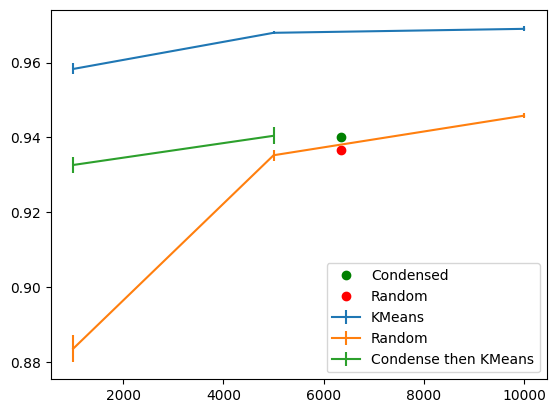

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.errorbar(exp1_M, exp1_kmm_accuracy, exp1_kmm_stddev, label='KMeans')
plt.errorbar(exp1_M, exp1_rand_accuracy, exp1_rand_stddev, label='Random')
plt.errorbar(exp3_M, exp3_kmm_accuracy, exp3_kmm_stddev, label='Condense then KMeans')
plt.plot([cnn_subset_ids.shape[0]], cnn_accuracy[-1], 'go', label='Condensed')
plt.plot([cnn_subset_ids.shape[0]], random_prototyping_accuracy[-1], 'ro', label='Random')
plt.legend()
plt.show()

In [ ]:
exp4_rand_idx = get_random_idx(6000, x_train.shape[0])
exp4_rand_data = np.take(x_train, exp4_rand_idx, axis=0)
exp4_rand_labels = np.take(y_train, exp4_rand_idx, axis=0)
checkpoint_file = 'cnn_subset_idxs.txt'

exp4_cnn_subset_ids = initialize_cnn_subset(checkpoint_file, y_train)
exp4_cnn_subset_ids = condense(exp4_cnn_subset_ids, exp4_rand_data, exp4_rand_labels, x_test, y_test, checkpoint_file)

rand_test_acc = run_knn(exp4_rand_data, exp4_rand_labels, x_test, y_test, 1)